<a href="https://colab.research.google.com/github/vjnbarot/Sephora-Skin-Care/blob/main/SephoraSkinCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score


from scipy.stats import ttest_ind


#Clone the original repository

In [ ]:
!git clone https://github.com/rosagradilla19/skincare-products-recommendation-system.git


Cloning into 'skincare-products-recommendation-system'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 94 (delta 37), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 779.02 KiB | 4.53 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
%cd skincare-products-recommendation-system

/content/skincare-products-recommendation-system


In [ ]:
!ls

Comparing-skincare-ingredients.ipynb  data    Procfile	 requirements.txt
comparing-skincare.py		      images  README.md  setup.sh


In [ ]:
!ls data

cosmetics.csv  image_1.jpg  image_2.jpg  test.py


In [ ]:
sephoradf = pd.read_csv('data/cosmetics.csv')
sephoradf.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


#Data Cleaning

In [ ]:
# Count missing values in each column
missing_counts = sephoradf.isnull().sum()

# Total number of missing values across the entire DataFrame
total_missing = missing_counts.sum()

print(f"Total missing values: {total_missing}")

# Drop rows with any missing values
sephoradf_cleaned= sephoradf.dropna()

# Print some info to verify
print(f"Original shape: {sephoradf.shape}")
print(f"Cleaned shape: {sephoradf_cleaned.shape}")


Total missing values: 0
Original shape: (1472, 11)
Cleaned shape: (1472, 11)


No missing values where found.

In [ ]:
# Display information about each column
print(sephoradf.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   int64  
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB
None


In [ ]:
# Unique values
for col in ['Label', 'Brand', 'Name', 'Ingredients']:
    print(f"{col} - unique values: {sephoradf[col].nunique()}")
    print(sephoradf[col].value_counts().head(), "\n")

Label - unique values: 6
Label
Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Name: count, dtype: int64 

Brand - unique values: 116
Brand
CLINIQUE              79
SEPHORA COLLECTION    66
SHISEIDO              63
ORIGINS               54
MURAD                 47
Name: count, dtype: int64 

Name - unique values: 1472
Name
Mineral Sport Sunscreen Stick SPF 50                                            1
Future Solution LX Total Protective Emulsion Broad Spectrum SPF 20 Sunscreen    1
Sun Lotion 30 SPF                                                               1
Virtu-oil Body Mist Broad Spectrum SPF 30                                       1
Sun Lotion 50 SPF                                                               1
Name: count, dtype: int64 

Ingredients - unique values: 1334
Ingredients
No Info                                  23
Visit the Dior boutique                  18
Visit the Shiseido boutique              10
Visit the SE

### Ingredient Analysis

Exported master cleaned ingredient list with 5274 unique ingredients.
Exported top ingredient counts.
Exported ingredient ratings with counts.


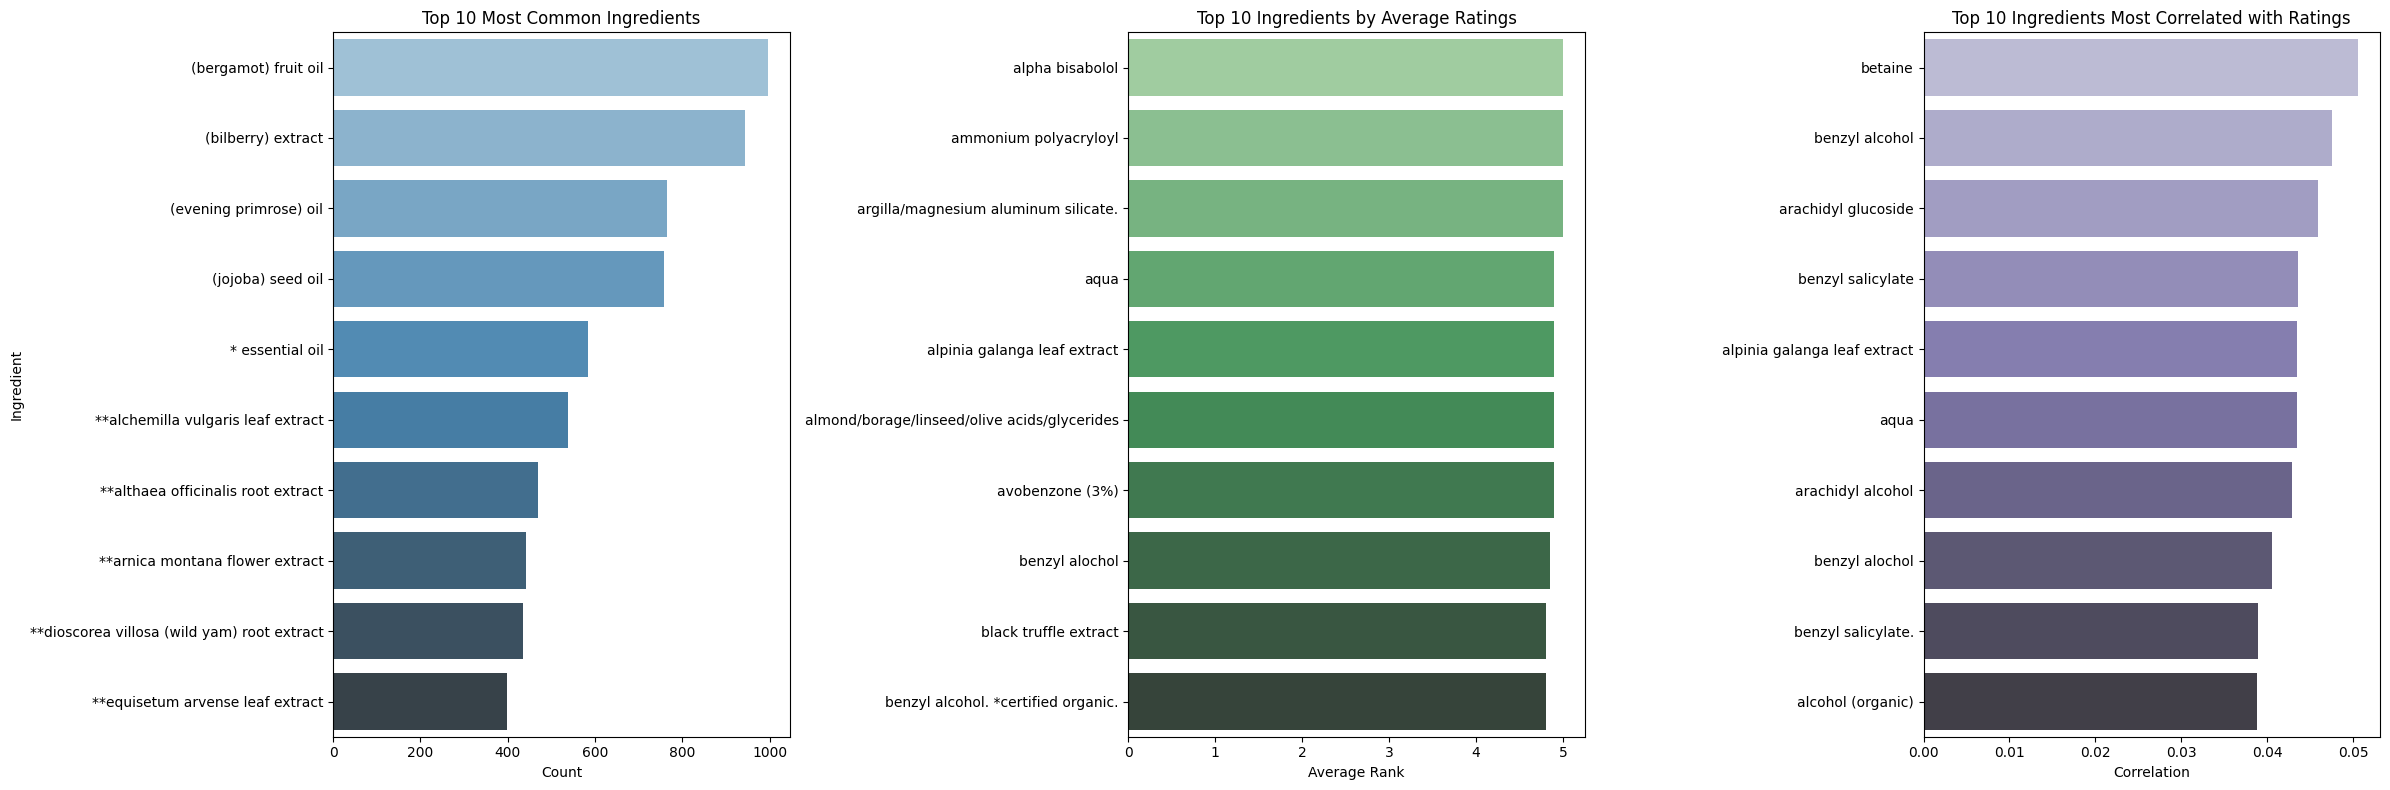

Saved combined side-by-side plots as 'side_by_side_ingredient_plots.png'.


In [ ]:


# Step 1: Define improved cleaning function
whitelist_keywords = [
    'extract', 'oil', 'acid', 'butter', 'wax', 'ester', 'protein',
    'peptide', 'ceramide', 'collagen', 'vitamin', 'enzyme', 'alcohol',
    'mineral', 'silicate', 'glycol', 'amide', 'retinol', 'caffeine'
]

def smart_extract_ingredients_advanced(text):
    parts = re.split(r',|-|;', str(text))
    cleaned = set()  # use a set to avoid duplicates
    for part in parts:
        part = part.strip().lower()  # lowercase everything
        if not part:
            continue
        if part.startswith(('and', 'with', 'to', 'for', 'step', 'in', 'on')):
            continue
        if len(part.split()) > 6:
            continue
        if any(kw in part for kw in ['™', 'compound', 'complex', 'carrier', 'sunscreen', 'paraben', 'pigment']):
            continue
        if ':' in part:
            part = part.split(':')[0].strip()
        if len(part) < 3:
            continue
        if not re.search('[a-zA-Z]', part):
            continue
        if re.match(r'^\d+$', part):
            continue
        if any(kw in part for kw in whitelist_keywords):
            cleaned.add(part)
            continue
        if re.match(r'^([a-z][a-z]+(\s|$)){1,3}', part):
            cleaned.add(part)
    return list(cleaned)

# Step 2: Apply to DataFrame
sephoradf['Ingredient_List_Clean'] = sephoradf['Ingredients'].apply(smart_extract_ingredients_advanced)

# Step 3: Build master unique ingredient list and export
all_clean_ingredients = [ing for sublist in sephoradf['Ingredient_List_Clean'] for ing in sublist]
unique_clean_ingredients = sorted(set(all_clean_ingredients))
pd.DataFrame({'Ingredient': unique_clean_ingredients}).to_csv('master_cleaned_ingredient_list.csv', index=False)
print(f"Exported master cleaned ingredient list with {len(unique_clean_ingredients)} unique ingredients.")

# Step 4: One-hot encode ingredients
mlb = MultiLabelBinarizer()
ingredient_dummies = pd.DataFrame(mlb.fit_transform(sephoradf['Ingredient_List_Clean']),
                                  columns=mlb.classes_,
                                  index=sephoradf.index)
sephoradf_with_ingredients = pd.concat([sephoradf, ingredient_dummies], axis=1)

# Step 5: Analyze top ingredients
top_ingredients = ingredient_dummies.sum().sort_values(ascending=False)
top_ingredients.to_csv('top_ingredient_counts.csv')
print(f"Exported top ingredient counts.")

# Step 6: Calculate average ratings
ingredient_ratings = {}
for ingredient in mlb.classes_:
    avg_rating = sephoradf_with_ingredients.loc[sephoradf_with_ingredients[ingredient] == 1, 'Rank'].mean()
    ingredient_ratings[ingredient] = avg_rating

ingredient_ratings_df = pd.DataFrame({
    'Ingredient': list(ingredient_ratings.keys()),
    'Average_Rank': list(ingredient_ratings.values()),
    'Count': top_ingredients.values
}).sort_values(by='Average_Rank', ascending=False)

ingredient_ratings_df.to_csv('ingredient_ratings.csv', index=False)
print(f"Exported ingredient ratings with counts.")

# Step 7: Filter for visualization
top_n = 10
min_count = 10
filtered = ingredient_ratings_df[ingredient_ratings_df['Count'] >= min_count]

# Set up side-by-side plots
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# 1️⃣ Top Most Common Ingredients
top_common = filtered.sort_values('Count', ascending=False).head(top_n)
sns.barplot(y='Ingredient', x='Count', hue='Ingredient', data=top_common, ax=axs[0], palette='Blues_d', legend=False)
axs[0].set_title(f'Top {top_n} Most Common Ingredients')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Ingredient')

# 2️⃣ Top Ingredients by Average Rating
top_rated = filtered.sort_values('Average_Rank', ascending=False).head(top_n)
sns.barplot(y='Ingredient', x='Average_Rank', hue='Ingredient', data=top_rated, ax=axs[1], palette='Greens_d', legend=False)
axs[1].set_title(f'Top {top_n} Ingredients by Average Ratings')
axs[1].set_xlabel('Average Rank')
axs[1].set_ylabel('')

# 3️⃣ Ingredients Most Correlated with Ratings
correlations = []
for ingredient in mlb.classes_:
    if ingredient in sephoradf_with_ingredients.columns:
        corr = sephoradf_with_ingredients[[ingredient, 'Rank']].corr().iloc[0, 1]
        correlations.append((ingredient, corr))

correlation_df = pd.DataFrame(correlations, columns=['Ingredient', 'Correlation']).dropna()
correlation_df = correlation_df[correlation_df['Ingredient'].isin(filtered['Ingredient'])]
top_correlated = correlation_df.sort_values('Correlation', ascending=False).head(top_n)

sns.barplot(y='Ingredient', x='Correlation', hue='Ingredient', data=top_correlated, ax=axs[2], palette='Purples_d', legend=False)
axs[2].set_title(f'Top {top_n} Ingredients Most Correlated with Ratings')
axs[2].set_xlabel('Correlation')
axs[2].set_ylabel('')

plt.tight_layout()
plt.savefig('side_by_side_ingredient_plots.png')
plt.show()
print("Saved combined side-by-side plots as 'side_by_side_ingredient_plots.png'.")



### Top Brands

<ipython-input-40-b3c61a1a869e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_brands_df['Brand'] = pd.Categorical(


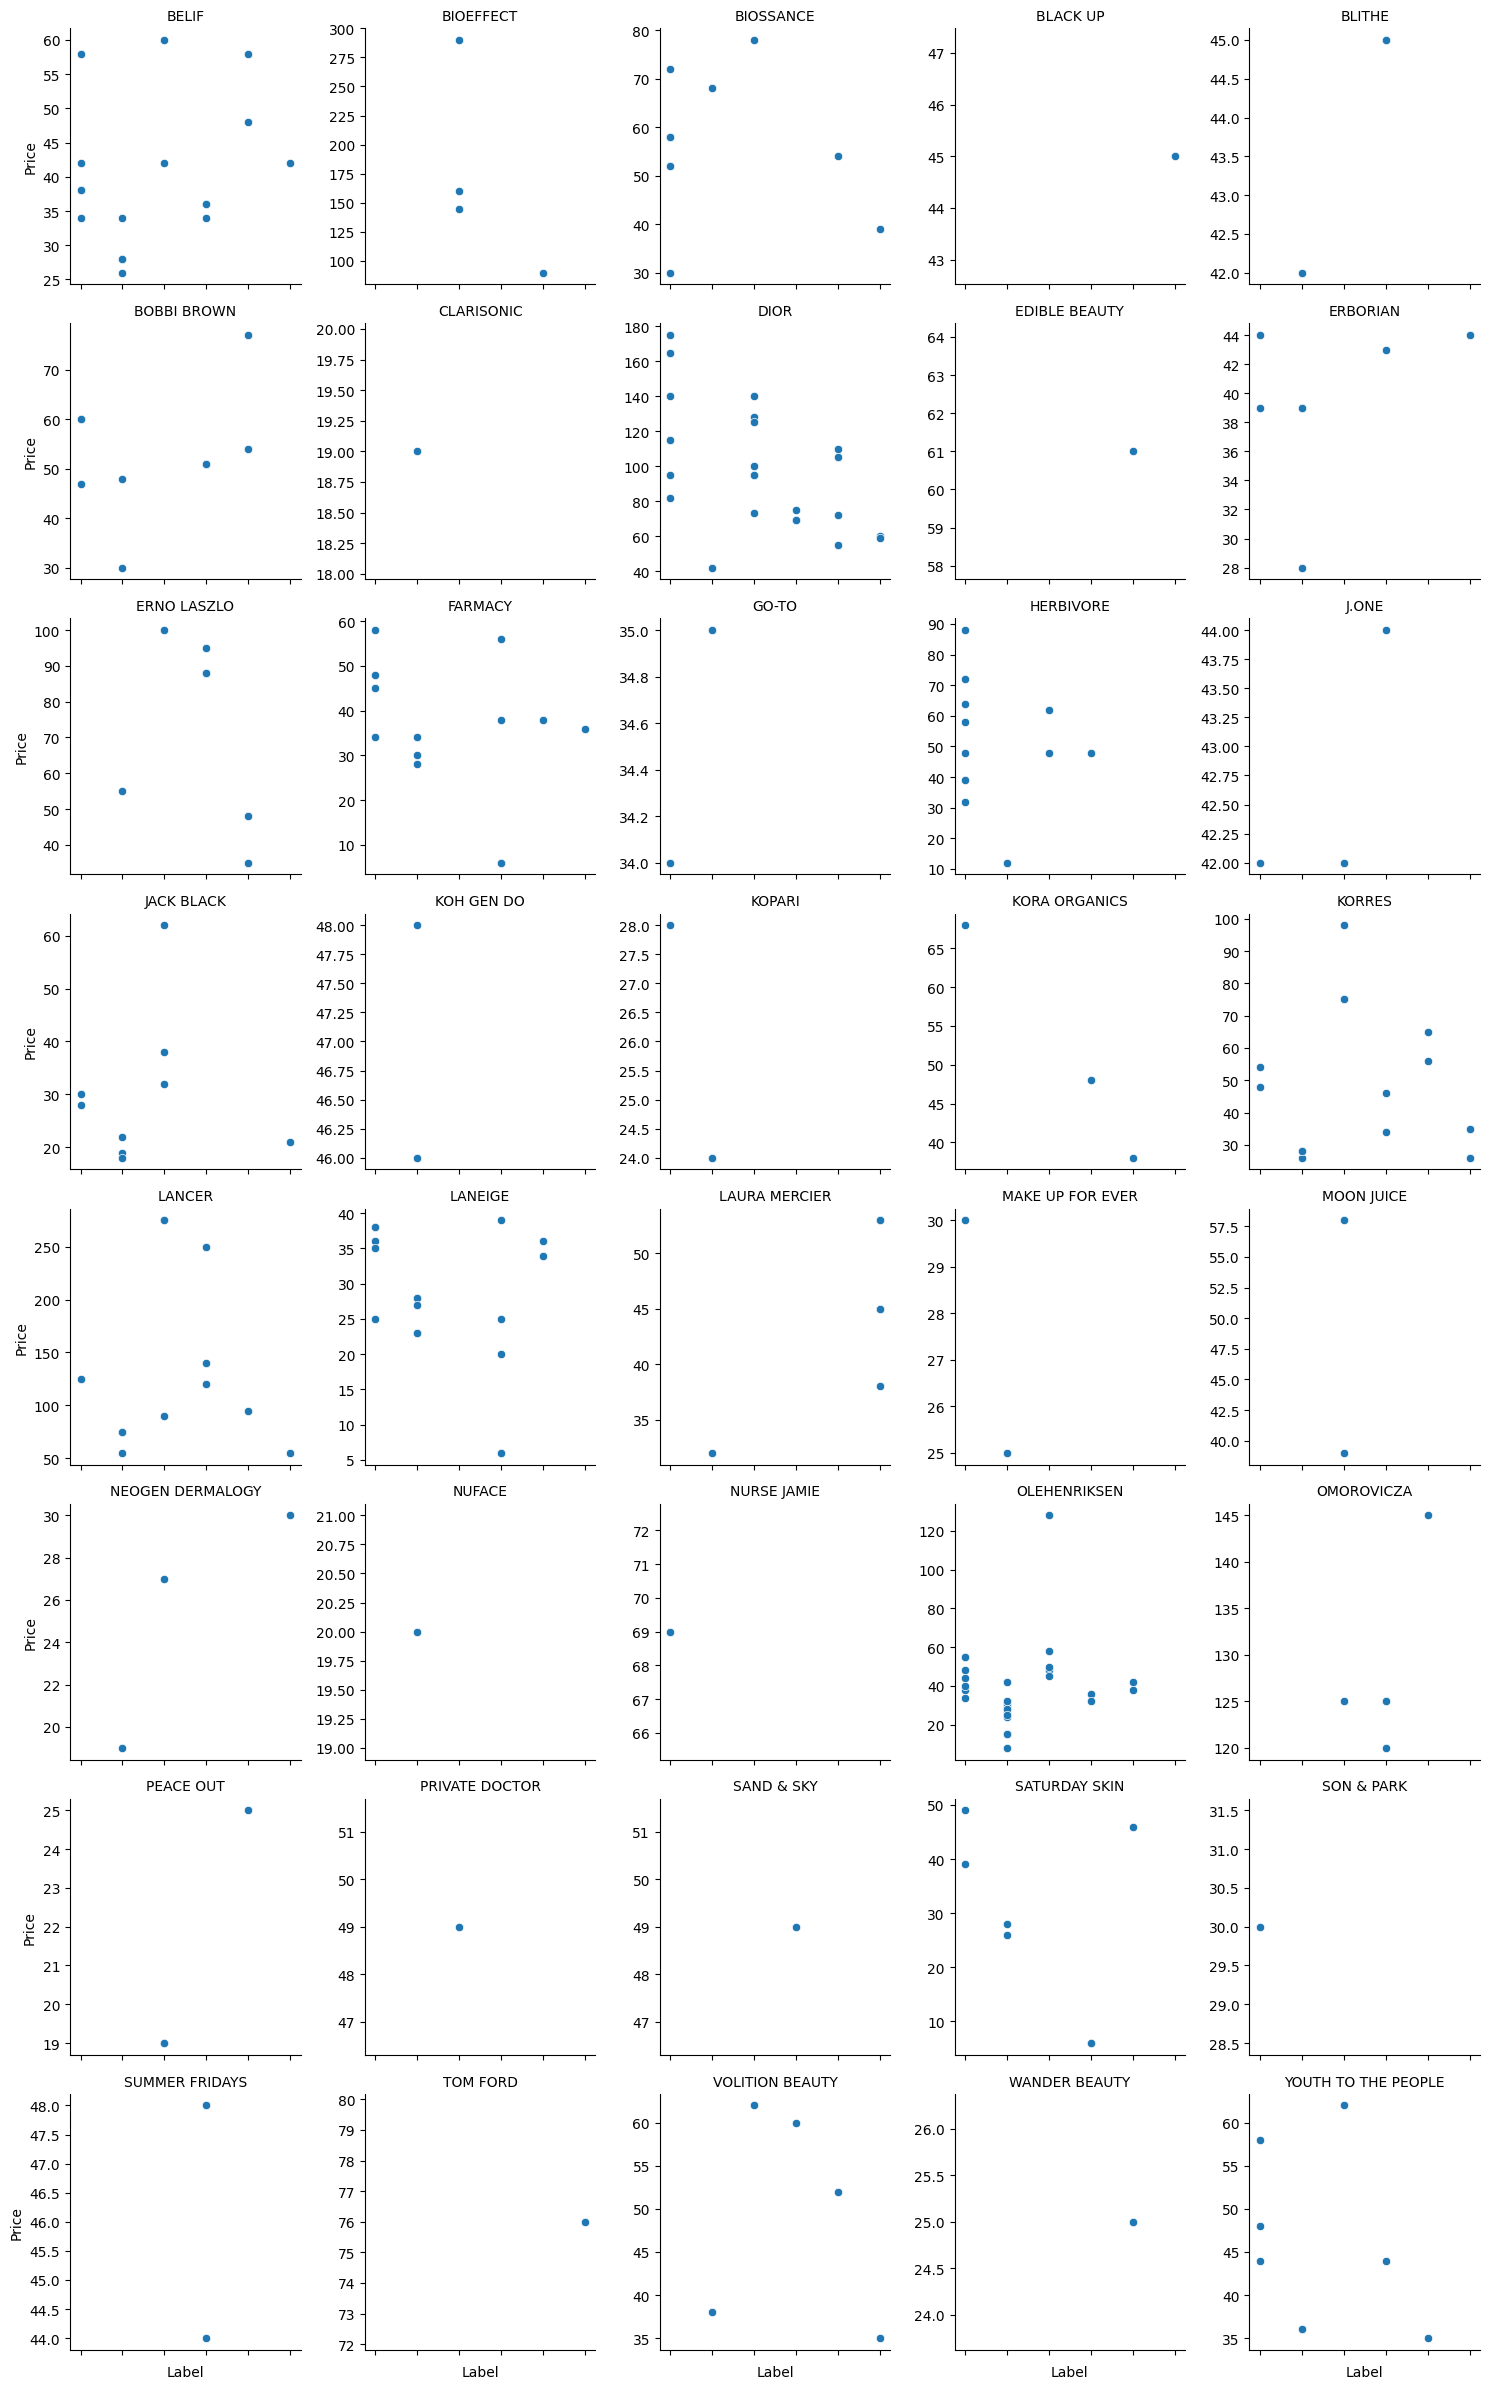

In [ ]:
# Step 1: Get top 40 brands by average rating
top_n = 40




# Step 2: Sort the brand names alphabetically
top_brands_sorted = sorted(top_brands)

# Step 3: Filter dataframe
top_brands_df = sephoradf[sephoradf['Brand'].isin(top_brands_sorted)]

# Step 4: Ensure 'Brand' is categorical with sorted order
top_brands_df['Brand'] = pd.Categorical(
    top_brands_df['Brand'],
    categories=top_brands_sorted,
    ordered=True
)

# Step 5: Plot
g = sns.FacetGrid(top_brands_df, col='Brand', col_wrap=5, height=3, sharey=False)
g.map_dataframe(sns.scatterplot, x='Label', y='Price')
g.set_titles('{col_name}')
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()
top_brands = (
    sephoradf.groupby('Brand')['Rank']
    .mean()
    .sort_values(ascending=False)
    .head(top_n)
    .index
)




In [ ]:

# Step 1: Group by Brand and calculate summary stats
brand_summary = sephoradf.groupby('Brand').agg(
    Average_Price=('Price', 'mean'),
    Min_Price=('Price', 'min'),
    Max_Price=('Price', 'max'),
    Num_Products=('Name', 'count'),
    Average_Rating=('Rank', 'mean')
)

# Step 2: Find most common Label per Brand
most_common_label = (
    sephoradf.groupby(['Brand', 'Label'])
    .size()
    .reset_index(name='Count')
    .sort_values(['Brand', 'Count'], ascending=[True, False])
    .drop_duplicates(subset=['Brand'])
    .set_index('Brand')['Label']
)

# Step 3: Merge into summary table
brand_summary['Most_Common_Label'] = most_common_label

# Step 4: Sort by Average_Price (or change this to 'Average_Rating' or 'Num_Products')
brand_summary = brand_summary.sort_values('Average_Price', ascending=False)

# Step 5: Export to CSV
brand_summary.to_csv('brand_summary_insights.csv')
print( "Exported brand summary insights to 'brand_summary_insights.csv'.")

# Step 6: Print top 20 brands summary
print("\nTop 20 Brands by Average Price:")
print(brand_summary.head(20).round(2))




Exported brand summary insights to 'brand_summary_insights.csv'.

Top 20 Brands by Average Price:
                    Average_Price  Min_Price  Max_Price  Num_Products  \
Brand                                                                   
LA MER                     184.33         25        370            30   
BIOEFFECT                  171.25         90        290             4   
LIGHTSTIM                  169.00        169        169             1   
SK-II                      156.94         70        240            17   
LANCER                     135.83         55        275            12   
OMOROVICZA                 128.00        120        145             5   
GUERLAIN                   118.83         29        230             6   
AMOREPACIFIC               103.52         32        260            21   
KAPLAN MD                  100.00        100        100             1   
DIOR                        95.26         42        175            27   
EVE LOM                   

<ipython-input-51-17574a1b690e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Tier', y='Rank', data=sephoradf, palette='pastel')


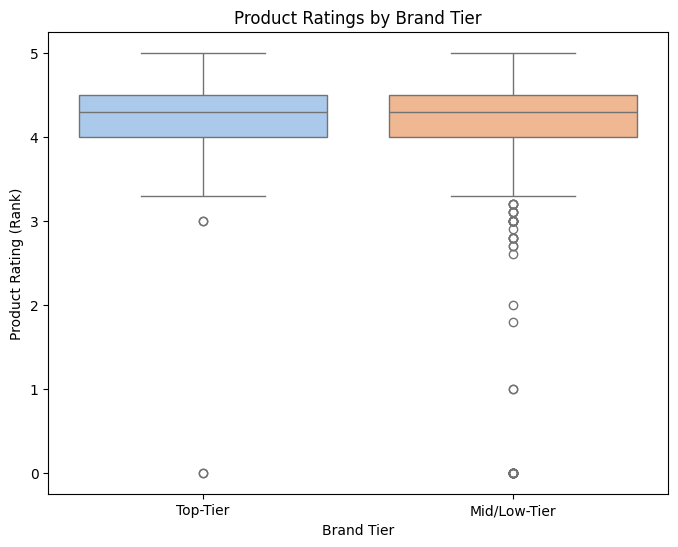

T-test result: t-statistic = 0.606, p-value = 0.546
No statistically significant difference in average ratings between Top-Tier and Mid/Low-Tier brands.
Correlation between Average Brand Price and Average Rating: 0.041


In [ ]:


# Step 1: Define top-tier threshold and categorize brands
price_threshold = 100  # you can adjust this value
brand_summary['Tier'] = brand_summary['Average_Price'].apply(
    lambda x: 'Top-Tier' if x >= price_threshold else 'Mid/Low-Tier'
)

# Step 2: Safely drop any existing 'Tier' column before merging
if 'Tier' in sephoradf.columns:
    sephoradf = sephoradf.drop(columns=['Tier'])

# Merge Tier info back into the main dataframe
sephoradf = sephoradf.merge(
    brand_summary[['Tier']],
    left_on='Brand',
    right_index=True
)

# Step 3: Visualize rating distributions by brand tier
plt.figure(figsize=(8, 6))
sns.boxplot(x='Tier', y='Rank', data=sephoradf, palette='pastel')
plt.title('Product Ratings by Brand Tier')
plt.ylabel('Product Rating (Rank)')
plt.xlabel('Brand Tier')
plt.show()

# Step 4: Perform statistical test (t-test) between tiers
top_tier_ratings = sephoradf[sephoradf['Tier'] == 'Top-Tier']['Rank']
midlow_tier_ratings = sephoradf[sephoradf['Tier'] == 'Mid/Low-Tier']['Rank']

# Check if both groups have enough data
if len(top_tier_ratings) > 1 and len(midlow_tier_ratings) > 1:
    t_stat, p_value = ttest_ind(top_tier_ratings, midlow_tier_ratings, equal_var=False)
    print(f"T-test result: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

    if p_value < 0.05:
        print("There is a statistically significant difference in average ratings between Top-Tier and Mid/Low-Tier brands.")
    else:
        print("No statistically significant difference in average ratings between Top-Tier and Mid/Low-Tier brands.")
else:
    print("Not enough data in one or both groups to perform t-test.")

# Step 5: Calculate correlation between average price and average rating
correlation = brand_summary['Average_Price'].corr(brand_summary['Average_Rating'])
print(f"Correlation between Average Brand Price and Average Rating: {correlation:.3f}")


In [ ]:
# Step 6: Print list of Top-Tier brands
top_tier_brands = brand_summary[brand_summary['Tier'] == 'Top-Tier'].index.tolist()
midlow_tier_brands = brand_summary[brand_summary['Tier'] == 'Mid/Low-Tier'].index.tolist()

print("\nTop-Tier Brands:")
for brand in top_tier_brands:
    print(f"- {brand}")

print("\nMid/Low-Tier Brands:")
for brand in midlow_tier_brands:
    print(f"- {brand}")



Top-Tier Brands:
- LA MER
- BIOEFFECT
- LIGHTSTIM
- SK-II
- LANCER
- OMOROVICZA
- GUERLAIN
- AMOREPACIFIC
- KAPLAN MD

Mid/Low-Tier Brands:
- DIOR
- EVE LOM
- PERRICONE MD
- TATA HARPER
- TOM FORD
- FRESH
- YVES SAINT LAURENT
- ERNO LASZLO
- SHISEIDO
- SUNDAY RILEY
- ESTÉE LAUDER
- ALGENIST
- LANCÔME
- NURSE JAMIE
- DR. BRANDT SKINCARE
- DR. DENNIS GROSS SKINCARE
- TATCHA
- L'OCCITANE
- DERMADOCTOR
- KATE SOMERVILLE
- SKIN INC SUPPLEMENT BAR
- EDIBLE BEAUTY
- CHARLOTTE TILBURY
- PETER THOMAS ROTH
- CLARINS
- BIOSSANCE
- MURAD
- CAUDALIE
- GLAMGLOW
- BOBBI BROWN
- HERBIVORE
- KORA ORGANICS
- DRUNK ELEPHANT
- KENZOKI
- FARSÁLI
- KORRES
- VITA LIBERATA
- VOLITION BEAUTY
- PRIVATE DOCTOR
- SAND & SKY
- MOON JUICE
- PHILOSOPHY
- CANE + AUSTIN
- FOREO
- KOH GEN DO
- YOUTH TO THE PEOPLE
- BEAUTYBIO
- SUMMER FRIDAYS
- BLACK UP
- DERMAFLASH
- LAURA MERCIER
- SKIN LAUNDRY
- BLITHE
- REN CLEAN SKINCARE
- NATURALLY SERIOUS
- INDIE LEE
- J.ONE
- BECCA
- NARS
- JOSIE MARAN
- IT COSMETICS
- SMASHBOX

###Skin Types, Pricing, and Ratings


Analyzing price vs. suitability for Dry skin:
  Average Price (Suitable): $57.92
  Average Price (Not Suitable): $51.86
  T-test: t = 2.575, p = 0.010
  → Statistically significant price difference!

Analyzing price vs. suitability for Normal skin:
  Average Price (Suitable): $57.20
  Average Price (Not Suitable): $52.55
  T-test: t = 1.925, p = 0.054
  → No statistically significant price difference!

Analyzing price vs. suitability for Oily skin:
  Average Price (Suitable): $55.73
  Average Price (Not Suitable): $55.36
  T-test: t = 0.153, p = 0.879
  → No statistically significant price difference!

Analyzing price vs. suitability for Sensitive skin:
  Average Price (Suitable): $55.92
  Average Price (Not Suitable): $55.23
  T-test: t = 0.293, p = 0.770
  → No statistically significant price difference!


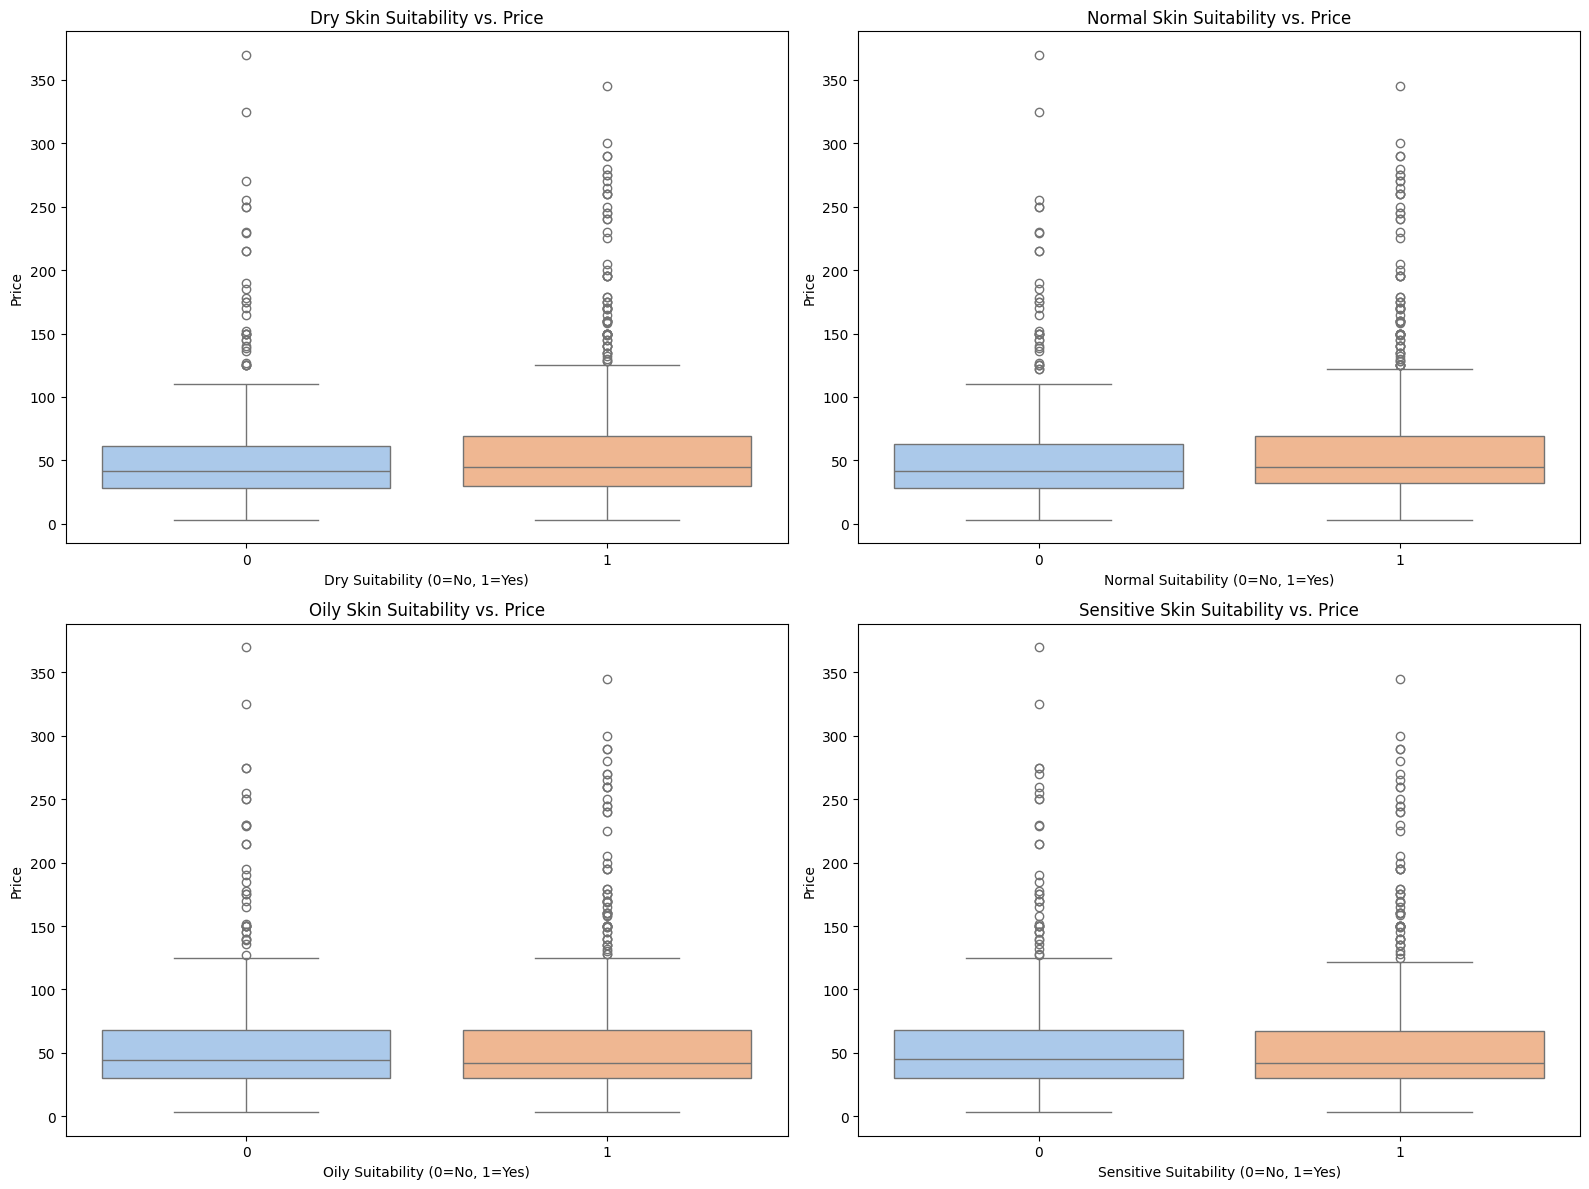

In [ ]:


skin_types = ['Dry', 'Normal', 'Oily', 'Sensitive']

# Create 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()  # Flatten to easily index in a loop

for i, skin in enumerate(skin_types):
    suitable = sephoradf[sephoradf[skin] == 1]['Price']
    not_suitable = sephoradf[sephoradf[skin] == 0]['Price']

    if len(suitable) > 1 and len(not_suitable) > 1:
        t_stat, p_value = ttest_ind(suitable, not_suitable, equal_var=False)
        avg_suitable = suitable.mean()
        avg_not_suitable = not_suitable.mean()

        print(f"\nAnalyzing price vs. suitability for {skin} skin:")
        print(f"  Average Price (Suitable): ${avg_suitable:.2f}")
        print(f"  Average Price (Not Suitable): ${avg_not_suitable:.2f}")
        print(f"  T-test: t = {t_stat:.3f}, p = {p_value:.3f}")

        if p_value < 0.05:
            print("  → Statistically significant price difference!")
        else:
            print("  → No statistically significant price difference!")

        sns.boxplot(
            x=sephoradf[skin],
            y=sephoradf['Price'],
            hue=sephoradf[skin],
            palette='pastel',
            legend=False,
            ax=axs[i]
        )
        axs[i].set_title(f'{skin} Skin Suitability vs. Price')
        axs[i].set_xlabel(f'{skin} Suitability (0=No, 1=Yes)')
        axs[i].set_ylabel('Price')

    else:
        print(f"  Not enough data for {skin} group.")

plt.tight_layout()
plt.show()


The boxplots for each skin type (Dry, Normal, Oily, Sensitive) show very

similar price distributions between products labeled 0 (not suitable) and 1 (suitable).

There’s no obvious shift or jump in median (the thick horizontal line in each box).

The interquartile ranges (the box height) and the spread of outliers (dots) look similar across the 0 and 1 groups.

Cluster counts:
Cluster
0    875
1    497
2     77
3     23
Name: count, dtype: int64


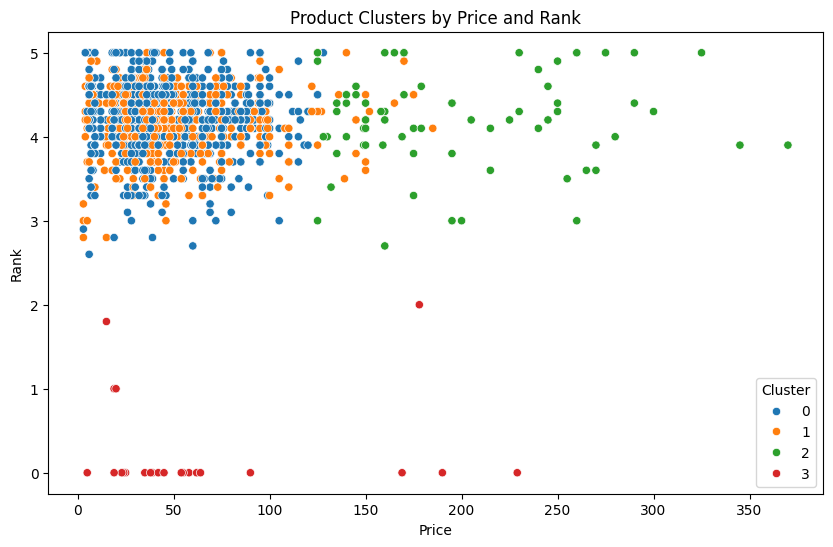


Cluster Feature Averages:
          Price  Rank   Dry  Normal  Oily  Sensitive  Num_Ingredients
Cluster                                                              
0         46.99  4.22  0.93    1.00  0.92       0.78            28.80
1         48.77  4.21  0.03    0.02  0.05       0.02            26.36
2        194.40  4.22  0.87    0.90  0.78       0.71            38.44
3         65.13  0.25  0.48    0.43  0.43       0.35            27.83


In [ ]:


# Step 1: Prepare data
sephoradf['Num_Ingredients'] = sephoradf['Ingredient_List_Clean'].apply(len)
features = ['Price', 'Rank', 'Dry', 'Normal', 'Oily', 'Sensitive', 'Num_Ingredients']

X = sephoradf[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply KMeans
n_clusters = 4  # adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
sephoradf['Cluster'] = kmeans.fit_predict(X_scaled)

print("Cluster counts:")
print(sephoradf['Cluster'].value_counts())

# Step 3: Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sephoradf, x='Price', y='Rank', hue='Cluster', palette='tab10')
plt.title('Product Clusters by Price and Rank')
plt.xlabel('Price')
plt.ylabel('Rank')
plt.show()

# Step 4: Analyze cluster characteristics
cluster_summary = sephoradf.groupby('Cluster')[features].mean()
print("\nCluster Feature Averages:")
print(cluster_summary.round(2))


In [ ]:

# Get centroid coordinates from KMeans (these are in scaled space)
centroids_scaled = kmeans.cluster_centers_

# Transform back to original feature space (optional but more interpretable)
centroids_original = pd.DataFrame(
    scaler.inverse_transform(centroids_scaled),
    columns=features
)

print("\nCluster Centroids (Original Feature Space):")
print(centroids_original.round(2))



Cluster Centroids (Original Feature Space):
    Price  Rank   Dry  Normal  Oily  Sensitive  Num_Ingredients
0   46.99  4.22  0.93    1.00  0.92       0.78            28.80
1   48.77  4.21  0.03    0.02  0.05       0.02            26.36
2  194.40  4.22  0.87    0.90  0.78       0.71            38.44
3   65.13  0.25  0.48    0.43  0.43       0.35            27.83


###Cluster 0
| Feature                      | Value     | Interpretation                                       |
| ---------------------------- | --------- | ---------------------------------------------------- |
| Price                        | 46.99     | Moderate price (\~\$47)                              |
| Rank                         | 4.22      | High average rating                                  |
| Dry, Normal, Oily, Sensitive | \~0.9–1.0 | Suitable for most skin types (almost always flagged) |
| Num\_Ingredients             | 28.8      | Moderate-to-high ingredient count                    |


###Cluster 1
| Feature                      | Value       | Interpretation                         |
| ---------------------------- | ----------- | -------------------------------------- |
| Price                        | 48.77       | Similar affordable price (\~\$49)      |
| Rank                         | 4.21        | High average rating                    |
| Dry, Normal, Oily, Sensitive | \~0.02–0.05 | Rarely labeled for specific skin types |
| Num\_Ingredients             | 26.36       | Slightly fewer ingredients             |


In [ ]:
# Show 5 sample products from each cluster
for cluster_id in sorted(sephoradf['Cluster'].unique()):
    sample = sephoradf[sephoradf['Cluster'] == cluster_id][['Brand', 'Name', 'Price', 'Rank']].head(5)
    print(f"\nCluster {cluster_id} Sample Products:")
    print(sample)



Cluster 0 Sample Products:
            Brand                                           Name  Price  Rank
2  DRUNK ELEPHANT                     Protini™ Polypeptide Cream     68   4.4
4    IT COSMETICS  Your Skin But Better™ CC+™ Cream with SPF 50+     38   4.1
5          TATCHA                                The Water Cream     68   4.2
6  DRUNK ELEPHANT                      Lala Retro™ Whipped Cream     60   4.2
7  DRUNK ELEPHANT                Virgin Marula Luxury Facial Oil     72   4.4

Cluster 1 Sample Products:
                Brand                                               Name  \
10              FRESH                   Lotus Youth Preserve Moisturizer   
18              FRESH                    Rose Deep Hydration Moisturizer   
21       BAREMINERALS  COMPLEXION RESCUE™ Tinted Moisturizer Broad Sp...   
22           SHISEIDO  Bio-Performance Advanced Super Revitalizing Cream   
25  CHARLOTTE TILBURY                            Charlotte's Magic Cream   

    Price  Rank  
1

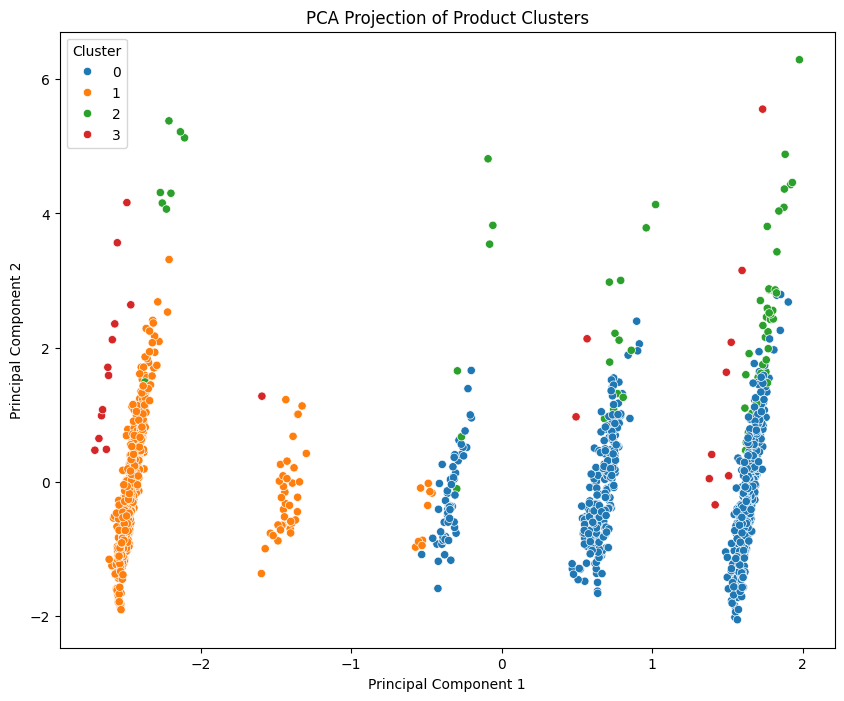

In [ ]:

# Reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add to dataframe
sephoradf['PCA1'] = X_pca[:, 0]
sephoradf['PCA2'] = X_pca[:, 1]

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(data=sephoradf, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title('PCA Projection of Product Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Get top 3 brands per cluster
for cluster_id in sorted(sephoradf['Cluster'].unique()):
    brand_counts = sephoradf[sephoradf['Cluster'] == cluster_id]['Brand'].value_counts().head(3)
    print(f"\nCluster {cluster_id} Top Brands:")
    print(brand_counts)

# Get top 3 product labels per cluster
for cluster_id in sorted(sephoradf['Cluster'].unique()):
    label_counts = sephoradf[sephoradf['Cluster'] == cluster_id]['Label'].value_counts().head(3)
    print(f"\nCluster {cluster_id} Top Product Labels:")
    print(label_counts)



Cluster 0 Top Brands:
Brand
DR. JART+             38
ORIGINS               36
KIEHL'S SINCE 1851    36
Name: count, dtype: int64

Cluster 1 Top Brands:
Brand
CLINIQUE              52
SEPHORA COLLECTION    41
SHISEIDO              32
Name: count, dtype: int64

Cluster 2 Top Brands:
Brand
LA MER          19
SK-II           10
AMOREPACIFIC     7
Name: count, dtype: int64

Cluster 3 Top Brands:
Brand
FOREO       2
LA MER      1
CLINIQUE    1
Name: count, dtype: int64

Cluster 0 Top Product Labels:
Label
Face Mask      186
Moisturizer    181
Cleanser       152
Name: count, dtype: int64

Cluster 1 Top Product Labels:
Label
Cleanser       124
Moisturizer     89
Treatment       75
Name: count, dtype: int64

Cluster 2 Top Product Labels:
Label
Moisturizer    25
Treatment      25
Eye cream      13
Name: count, dtype: int64

Cluster 3 Top Product Labels:
Label
Cleanser     5
Face Mask    5
Eye cream    5
Name: count, dtype: int64


In [ ]:

# Get actual cluster means
cluster_means = sephoradf.groupby('Cluster')[features].mean().round(2)
cluster_means['Type'] = 'Actual Mean'

# Get KMeans centroids (converted back to original scale)
centroids_original = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
).round(2)
centroids_original['Cluster'] = centroids_original.index
centroids_original['Type'] = 'Centroid'

# Combine both into one table
combined_summary = pd.concat([
    cluster_means.reset_index(),
    centroids_original[['Cluster', *features, 'Type']]
])

# Pivot to side-by-side format
final_table = combined_summary.pivot_table(
    index='Cluster',
    columns='Type',
    values=features
)

# Display table
with pd.option_context('display.max_columns', None):
    print("\nCluster Summary Side-by-Side (Actual Mean vs. Centroid):")
    print(final_table)



Cluster Summary Side-by-Side (Actual Mean vs. Centroid):
                Dry               Normal          Num_Ingredients           \
Type    Actual Mean Centroid Actual Mean Centroid     Actual Mean Centroid   
Cluster                                                                      
0              0.93     0.93        1.00     1.00           28.80    28.80   
1              0.03     0.03        0.02     0.02           26.36    26.36   
2              0.87     0.87        0.90     0.90           38.44    38.44   
3              0.48     0.48        0.43     0.43           27.83    27.83   

               Oily                Price                 Rank           \
Type    Actual Mean Centroid Actual Mean Centroid Actual Mean Centroid   
Cluster                                                                  
0              0.92     0.92       46.99    46.99        4.22     4.22   
1              0.05     0.05       48.77    48.77        4.21     4.21   
2              0.78     0